In [1]:
from pathlib import Path

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
cwd = Path(".")
data_dir = Path("../data")

In [3]:
!ls {data_dir}

label.geojson  metadata.csv  submission_format.csv  train_labels.csv


In [120]:
gdf = gpd.read_file(data_dir/"label.geojson")

In [121]:
gdf.head()

,uid,region,severity,density,latitude,longitude,date,split,geometry
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032)
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train,POINT (-78.87843 35.87508)
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train,POINT (-79.06213 35.48700)
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train,POINT (-99.82700 38.04947)
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train,POINT (-86.89835 39.47474)


In [122]:
def compute_bbox_around_points(gdf, buffer=1000):
    gdf = gdf.to_crs(epsg=3857)
    gdf["bbox"] = gdf["geometry"].apply(lambda g: box(*g.buffer(1000).bounds))
    gdf = gdf.to_crs(epsg=4326)
    gdf.bbox = gdf.bbox.to_crs(epsg=4326)
    return gdf

In [123]:
gdf = compute_bbox_around_points(gdf)

In [124]:
gdf.head()

,uid,region,severity,density,latitude,longitude,date,split,geometry,bbox
0,aabm,midwest,1,585.0,39.080319,-86.430867,2018-05-14,train,POINT (-86.43087 39.08032),"POLYGON ((-86.42188 39.07335, -86.42188 39.087..."
1,aacd,south,1,290.0,35.875083,-78.878434,2020-11-19,train,POINT (-78.87843 35.87508),"POLYGON ((-78.86945 35.86780, -78.86945 35.882..."
2,aaee,south,1,1614.0,35.487000,-79.062133,2016-08-24,train,POINT (-79.06213 35.48700),"POLYGON ((-79.05315 35.47969, -79.05315 35.494..."
3,aaff,midwest,3,111825.0,38.049471,-99.827001,2019-07-23,train,POINT (-99.82700 38.04947),"POLYGON ((-99.81802 38.04240, -99.81802 38.056..."
4,aafl,midwest,4,2017313.0,39.474744,-86.898353,2021-08-23,train,POINT (-86.89835 39.47474),"POLYGON ((-86.88937 39.46781, -86.88937 39.481..."


In [127]:
from dateutil.relativedelta import relativedelta

def compute_date_range(date, delta):
    # Compute date range prior to delta
    prior_date = date + relativedelta(days=-delta)
    return f"{prior_date.strftime('%Y-%m-%d')}/{date.strftime('%Y-%m-%d')}" 

# Example usage
now = sample.date
date_range = compute_date_range(now, 15)
print("Date range prior to 15 days:", date_range)

Date range prior to 15 days: 2020-11-04/2020-11-19


In [128]:
from pystac_client import Client
import planetary_computer as pc

In [201]:
import concurrent.futures

(data_dir/"chips"/"visual-1km-radius").mkdir(exist_ok=True, parents=True)
def download_image(sample):
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=sample.bbox.bounds,
        datetime=compute_date_range(sample.date, 15),
        query=["eo:cloud_cover<25"]
    )
    if len(search.get_all_items()):
        items = list()
        #iterate over the results
        for item in search.get_all_items():
            item_bbox = box(*item.bbox)
            point_bbox = sample.bbox
            if item_bbox.contains(point_bbox):
                items.append(item)
                
        # sort items based on cloud_cover
        items = sorted(items, key=lambda x: x.properties["eo:cloud_cover"])
        
        # save the image with least cloud_cover
        img = rioxarray.open_rasterio(items[0]\
                                    .assets["visual"].href)\
                                    .rio.clip_box(*sample.bbox.bounds, 
                                                  crs="EPSG:4326")
        print(img.data.shape)
        cv2.imwrite(f"{data_dir}/chips/visual-1km-radius/{sample['uid']}.png", img.data.transpose(1,2,0))

with concurrent.futures.ThreadPoolExecutor() as executor:
    samples = list(gdf.iterrows())[:10]
    executor.map(download_image, samples)

In [199]:
import cv2

for _,sample in list(gdf.iterrows())[:10]:
    from shapely.geometry import Point
    catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

    search = catalog.search(
        collections=["sentinel-2-l2a"],
        bbox=sample.bbox.bounds,
        datetime=compute_date_range(sample.date, 15),
        query=["eo:cloud_cover<25"]
    )
    if len(search.get_all_items()):
        items = list()
        #iterate over the results
        for item in search.get_all_items():
            item_bbox = box(*item.bbox)
            point_bbox = sample.bbox
            if item_bbox.contains(point_bbox):
                items.append(item)
                
        # sort items based on cloud_cover
        items = sorted(items, key=lambda x: x.properties["eo:cloud_cover"])
        
        # save the image with least cloud_cover
        img = rioxarray.open_rasterio(items[0]\
                                    .assets["visual"].href)\
                                    .rio.clip_box(*sample.bbox.bounds, 
                                                  crs="EPSG:4326")
        
        cv2.imwrite(f"{sample['uid']}.png", img.data.transpose(1,2,0))

In [167]:
from shapely.geometry import Point
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1", modifier=pc.sign_inplace)

search = catalog.search(
    collections=["sentinel-2-l2a"],
    bbox=sample.bbox.bounds,
    datetime=compute_date_range(sample.date, 15),
    query=["eo:cloud_cover<25"]
)
print(len(search.get_all_items()))

items = list()
#iterate over the results
for item in search.get_all_items():
    item_bbox = box(*item.bbox)
    point_bbox = sample.bbox
    if item_bbox.contains(point_bbox):
        items.append(item)

5


In [168]:
items

[<Item id=S2B_MSIL2A_20210823T163839_R126_T16SEJ_20210824T042354>,
 <Item id=S2B_MSIL2A_20210823T163839_R126_T16SDJ_20210824T051720>,
 <Item id=S2B_MSIL2A_20210820T162829_R083_T16SEJ_20210821T065904>,
 <Item id=S2A_MSIL2A_20210808T163901_R126_T16SEJ_20210809T044518>,
 <Item id=S2A_MSIL2A_20210808T163901_R126_T16SDJ_20210809T050249>]

In [175]:
items2[0].assets["preview"].href

'https://sentinel2l2a01.blob.core.windows.net/sentinel2-l2/16/S/DJ/2021/08/23/S2B_MSIL2A_20210823T163839_N0300_R126_T16SDJ_20210824T051720.SAFE/GRANULE/L2A_T16SDJ_A023318_20210823T164440/QI_DATA/T16SDJ_20210823T163839_PVI.tif?st=2023-01-27T19%3A29%3A22Z&se=2023-01-28T20%3A14%3A22Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-01-28T16%3A14%3A27Z&ske=2023-02-04T16%3A14%3A27Z&sks=b&skv=2021-06-08&sig=kdaWzW2nfyefTIHTaXi3jXr/l8RZ2Ox57nuYY//hM60%3D'

In [169]:
items = sorted(items, key=lambda x: x.properties["eo:cloud_cover"])

In [171]:
for item in items2:
    print(item.properties["eo:cloud_cover"])

7.834672
10.65188
12.223859
20.010652
23.675313


In [178]:
import rioxarray

In [182]:
print(sample.bbox.bounds)

(-86.90733615284118, 39.4678095148038, -86.8893698471588, 39.48167779403886)


In [191]:
im = rioxarray.open_rasterio(items2[0].assets["visual"].href).rio.clip_box(*sample.bbox.bounds, crs="EPSG:4326")

In [196]:
im.data.shape

(3, 155, 156)

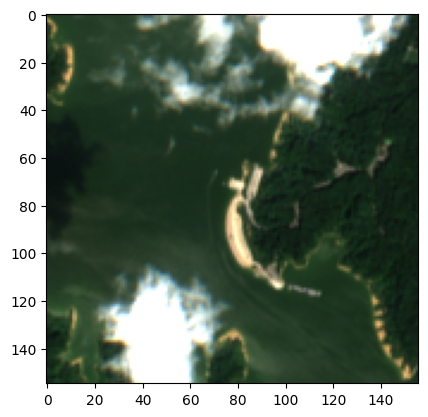

In [192]:
plt.imshow(im.data.transpose(1,2,0))